Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocess Training and Testing Data

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE


Load and Preprocess Data

In [ ]:
def load_images(folder_path, image_size):
    images = []
    for filename in os.listdir(folder_path):
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(gray_image, (image_size, image_size))
            images.append(resized_image.flatten())
    return images

def preprocess_data(data_path, image_size):
    training_data = {}
    testing_data = {}
    for tumor_type in ['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'no_tumor']:
        training_images = load_images(os.path.join(data_path, 'Training', tumor_type), image_size)
        testing_images = load_images(os.path.join(data_path, 'Testing', tumor_type), image_size)
        training_data[tumor_type] = training_images
        testing_data[tumor_type] = testing_images
    return training_data, testing_data


Extract Features

In [ ]:
def extract_features(image, image_size):
    reshaped_image = np.reshape(image, (image_size, image_size))
    features = hog(
        reshaped_image,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False
    )
    return features


Preprocess Training and Testing Data

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/dataset'
image_size = 256
training_data, testing_data = preprocess_data(data_path, image_size)

training_features = []
training_labels = []
for tumor_type, images in training_data.items():
    features = [extract_features(image, image_size) for image in images]
    training_features.extend(features)
    training_labels.extend([tumor_type] * len(features))


Dimensionality Reduction and Augmentation


In [ ]:
pca = PCA(n_components=50)
training_features_reduced = pca.fit_transform(training_features)

data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

augmented_training_images = []
augmented_training_labels = []

for tumor_type, images in training_data.items():
    for image in images:
        reshaped_image = np.reshape(image, (image_size, image_size, 1))
        reshaped_image = np.expand_dims(reshaped_image, axis=0)

        flow = data_gen.flow(
            reshaped_image,
            batch_size=1,
            seed=42
        )

        augmented_images = [next(flow)[0].flatten() for _ in range(5)]
        augmented_training_images.extend(augmented_images)
        augmented_training_labels.extend([tumor_type] * len(augmented_images))


SMOTE and SVM


In [ ]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(training_features_reduced, training_labels)

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    SVC(),
    param_grid,
    scoring='accuracy',
    cv=5
)

grid_search.fit(X_resampled, y_resampled)
classifier = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)


Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


Predict and Evaluate


In [ ]:
testing_features = []
testing_labels = []

for tumor_type, images in testing_data.items():
    if not images:
        print(f"No images found for {tumor_type}.")
        continue

    features = [extract_features(image, image_size) for image in images]
    if not features:
        print(f"No features extracted for {tumor_type}.")
        continue

    try:
        if len(features) > 0 and isinstance(features[0], np.ndarray):
            features = np.array(features).reshape(len(features), -1)

        reduced_features = pca.transform(features)
        testing_features.extend(reduced_features)
        testing_labels.extend([tumor_type] * len(reduced_features))
    except Exception as e:
        print(f"Error applying PCA for {tumor_type}: {e}")

if not testing_features or not testing_labels:
    raise ValueError("No valid test data for prediction.")

predictions = classifier.predict(testing_features)

accuracy = accuracy_score(testing_labels, predictions)
print("Test Accuracy:", accuracy * 100)

Test Accuracy: 76.14213197969542


Confusion Matrix and Classification Report


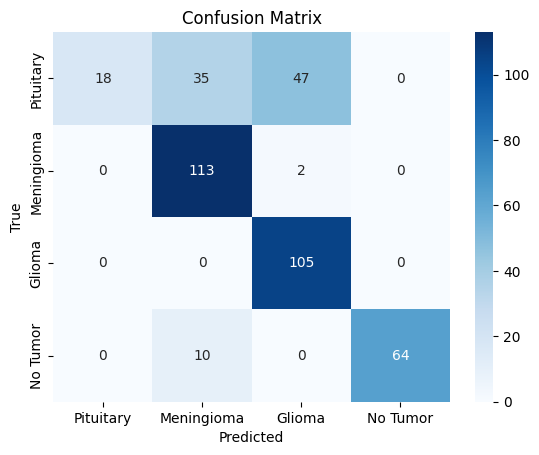

Classification Report:
              precision    recall  f1-score   support

   Pituitary       1.00      0.18      0.31       100
  Meningioma       0.72      0.98      0.83       115
      Glioma       0.68      1.00      0.81       105
    No Tumor       1.00      0.86      0.93        74

    accuracy                           0.76       394
   macro avg       0.85      0.76      0.72       394
weighted avg       0.83      0.76      0.71       394



In [ ]:
conf_matrix = confusion_matrix(testing_labels, predictions)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pituitary', 'Meningioma', 'Glioma', 'No Tumor'],
    yticklabels=['Pituitary', 'Meningioma', 'Glioma', 'No Tumor']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_report_str = classification_report(
    testing_labels,
    predictions,
    target_names=['Pituitary', 'Meningioma', 'Glioma', 'No Tumor']
)
print("Classification Report:")
print(classification_report_str)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Convert SVM classifier into a simple neural network
model = Sequential([
    Dense(units=num_support_vectors, input_dim=num_features, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Transpose the support vectors to match the expected input shape of the first layer
support_vectors = classifier.support_vectors_
num_support_vectors = support_vectors.shape[0]
num_features = support_vectors.shape[1]

# Reshape the support vectors to match the expected input shape of the first layer
reshaped_support_vectors = support_vectors.T

# Set the weights and biases of the first layer
model.layers[0].set_weights([reshaped_support_vectors, classifier.dual_coef_[0]])

# Save the model as H5 file
model.save('/content/drive/MyDrive/Colab Notebooks/svm_classifier.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Convert the model to TensorFlow.js format
!tensorflowjs_converter --input_format keras '/content/drive/MyDrive/Colab Notebooks/svm_classifier.h5' '/content/mnist-model'


2024-05-02 05:28:28.283847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {keras_saved_model,tfjs_layers_model,keras,tf_frozen_model,tf_hub,keras_keras,tf_saved_model}]
                                       [--output_format {keras_saved_model,tfjs_layers_model,tfjs_graph_model,keras_keras,keras}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}] [--split_weights_by_layer]
                                       [--version] [--skip_op_check]
       

In [ ]:
import joblib


# After training the model (after the grid_search.fit() call)
classifier = grid_search.best_estimator_

# Save the trained model to Google Drive
model_file = '/content/drive/MyDrive/Colab Notebooks/dataset/svc_model.pkl'  # Set the path where you want to save the model
joblib.dump(classifier, model_file)

# Print the path to the saved model file
print("Model saved to:", model_file)


Model saved to: /content/drive/MyDrive/Colab Notebooks/dataset/svc_model.pkl
